In [1]:
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tool import *
import numpy as np
import matplotlib.pylab as plt
import cv2
import numpy.ma as ma
import glob

def get_features(PATH):
    # read lena RGB image and convert to grayscale
    rgb_im = cv2.imread(PATH)
    gray_im = cv2.cvtColor(rgb_im, cv2.COLOR_BGR2GRAY)
    dct_img = dct2 (gray_im)

    #Get positive coef.
    dct_positive_coef, dct_negative_coef = np.array(dct_img), np.array(dct_img)

    np.putmask(dct_positive_coef, dct_positive_coef < 0, 0)
    np.putmask(dct_negative_coef, dct_negative_coef > 0, 0)


    idct_positive_img = idct2(dct_positive_coef)
    idct_negative_img = idct2(dct_negative_coef)

    # idct_positive_img = np.uint8(idct_positive_img) 
    # idct_negative_img = np.uint8(idct_negative_img) 
    # cv2.imwrite ('positive.jpg', idct_positive_img)
    # cv2.imwrite ('negative.jpg', idct_negative_img)

    #Apply laplacian filter
    positive_laplacian_img = laplace (idct_positive_img)
    negative_laplacian_img = laplace (idct_negative_img)

    # positive_laplacian_img = np.uint8(positive_laplacian_img) 
    # negative_laplacian_img = np.uint8(negative_laplacian_img) 

    #Fuse image
    fuse_img = (np.array (positive_laplacian_img) + np.array (negative_laplacian_img)) / 2.0

    fuse_img = np.uint8(fuse_img) 

    #Candy image
#     candy_fuse_img = candy (fuse_img)
#     sobel_fuse_img = sobel (fuse_img)

#     candy_original_img = candy (gray_im)
#     sobel_original_img = sobel (gray_im)

#     psnr_candy, mse_candy, ssim_candy = quality_features (candy_original_img, candy_fuse_img)
#     psnr_sobel, mse_sobel, ssim_sobel = quality_features (sobel_original_img, sobel_fuse_img)

#     img_quality_features = np.array ([psnr_candy, mse_candy, ssim_candy, psnr_sobel, mse_sobel, ssim_sobel])
#     img_quality_features = np.reshape (img_quality_features, (img_quality_features.shape [0],1))
    #print ('quality features',img_quality_features.shape)

    # calculate residual image
    residual_img = np.abs (fuse_img - np.array (gray_im))

    hist_residual = hist_features(residual_img)
    hist_fuse = hist_features(fuse_img)
    hist_original = hist_features(gray_im)

    cv2.normalize(hist_residual,hist_residual,0,1,cv2.NORM_MINMAX)
    cv2.normalize(hist_fuse,hist_fuse,0,1,cv2.NORM_MINMAX)
    cv2.normalize(hist_original,hist_original,0,1,cv2.NORM_MINMAX)
    diff_hist = np.abs (np.array (hist_original) - np.array (hist_fuse))

    img_features = np.concatenate ((hist_residual, hist_fuse, diff_hist), axis = 0)

#     img_features = np.reshape (img_features, (img_features.shape [0],))
    
    return img_features
    # print (img_features.shape)
    # plt.plot(hist_residual)
    # plt.show()

In [2]:
image_list =[]
label_list = []
for label in ['normal','slicing']:
    for PATH in glob.glob(r'train22\{}\*.jpg'.format(label)): 
        features = get_features(PATH)
        image_list.append(features)
        if label == 'normal':
            label_list.append(1)
        else:
            label_list.append(0)


In [3]:
import random

temp = list(zip(image_list, label_list))
random.shuffle(temp)
image_list, label_list = zip(*temp)
N = len(label_list)
Y = np.asarray(label_list)
X = np.zeros((N,75))
for i in range(0,N):
    X[i] = image_list[i].reshape(75,)
print(X.shape)
print(Y.shape)

(557, 75)
(557,)


In [4]:
# cnn 
EPOCHS = 100
BATCH_SIZE = 8
lr = 1e-4
n_features = 75
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten,MaxPooling1D,Dropout
import tensorflow as tf
from tensorflow.keras import optimizers
#create model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3,padding='same', activation='relu', input_shape=(n_features,1)))
model.add(Conv1D(filters=128, kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(strides =2,padding ='same'))
model.add(Conv1D(filters=32, kernel_size=3, padding='same',activation='relu'))
model.add(MaxPooling1D(strides =2,padding ='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(608,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=lr),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy(),
                       keras.metrics.AUC()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 75, 32)            128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 128)           12416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 38, 32)            12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 608)               0         
_________________________________________________________________
dropout (Dropout)            (None, 608)               0

In [5]:
X = X.reshape((N,n_features,1))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
tf.config.run_functions_eagerly(True)
history = model.fit(
    X,
    Y,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=my_callbacks
)


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/100
 1/56 [..............................] - ETA: 0s - loss: 0.6935 - binary_accuracy: 0.6250 - auc: 0.3667WARNING:tensorflow:From c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
56/56 [==============================] - 3s 49ms/step - loss: 0.6800 - binary_accuracy: 0.6607 - auc: 0.6722 - val_loss: 0.6500 - val_binary_accuracy: 0.6607 - val_auc: 0.8493
Epoch 2/100
56/56 [==============================] - 2s 43ms/step - loss: 0.6154 - binary_accuracy: 0.6966 - auc: 0.7732 - val_loss: 0.5237 - val_binary_accuracy: 0.7589 - val_auc: 0.8638
Epoch 3/100
56/56 [==============================] - 2s 44ms/step - loss: 0.5093 - binary_accuracy: 0.7483 - auc: 0.8436 - val_loss: 0.4437 - val_binary_accuracy: 0.8214 - val_auc: 0.8809
Epoch 4/100
56/56 [===

In [6]:
model.save_weights("model/model")

dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])


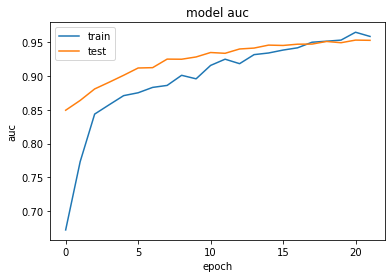

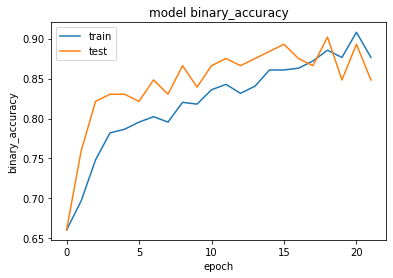

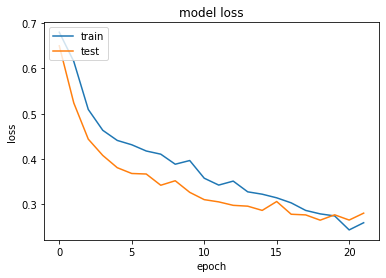

In [7]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for auc
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model binary_accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
image_list =[]
label_list = []
for label in ['normal','slicing']:
    for PATH in glob.glob(r'mytest\{}\*.jpg'.format(label)): 
        features = get_features(PATH)
        
        image_list.append(features)
        if label == 'normal':
            label_list.append(1)
        else:
            label_list.append(0)


In [9]:
            
import random
temp = list(zip(image_list, label_list))
random.shuffle(temp)
image_list, label_list = zip(*temp)
N = len(label_list)
Y = np.asarray(label_list)
X = np.zeros((N,75))
for i in range(0,N):
    X[i] = image_list[i].reshape(75,)
print(X.shape)
print(Y.shape)

(63, 75)
(63,)


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
n_features = 75
model.load_weights("model/model")
X = X.reshape((N,n_features,1))
y_pred = model.predict(X)
fpr, tpr, thresholds = metrics.roc_curve(Y,y_pred)
# print('acc = ',metrics.accuracy_score(Y,y_pred))
print('AUC = ',metrics.auc(fpr, tpr))

AUC =  0.9494736842105264


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
